Let's fetch cutouts of RA/Dec coords from the RACS images.

In [181]:
import collections
from pathlib import Path
import warnings

import astropy.io.fits as fits
from astropy.wcs import WCS
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from astropy.coordinates import SkyCoord as SC
import pandas
import sklearn.decomposition, sklearn.svm, sklearn.manifold, sklearn.ensemble, sklearn.linear_model, \
    sklearn.naive_bayes
import umap

In [2]:
racs_path = Path('/home/alger/possum/alger/racs-prerelease-10-07-19/')

In [3]:
coords = []
names = []
for racs in tqdm(list(racs_path.iterdir())):
    header = fits.getheader(racs)
    ra_ref = header['CRVAL1'] + header['CRPIX1'] * header['CDELT1'] / 2
    dec_ref = header['CRVAL2'] + header['CRPIX2'] * header['CDELT2'] / 2
    names.append(racs)
    coords.append((ra_ref, dec_ref))
coords = numpy.array(coords)

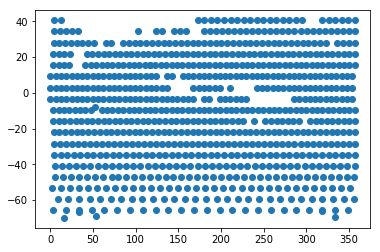

In [4]:
plt.scatter(*numpy.array(coords).T)

In [5]:
centre_coords = SC(ra=coords[:, 0], dec=coords[:, 1], unit='deg')

We have the whole sky. To find an object, locate the image it's in, open the image, then obtain the data.

In [6]:
def find_closest_image(coord):
    return names[coord.separation(centre_coords).argmin()]

In [7]:
find_closest_image(SC(ra=0, dec=0, unit='deg'))

PosixPath('/home/alger/possum/alger/racs-prerelease-10-07-19/image.i.SB8582.cont.RACS_test4_1.05_0012+00A.linmos.taylor.0.restored.fits')

In [8]:
def make_cutout(coord, path, radius: 'px'=20):
    with fits.open(path) as f, warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(f[0].header, fix=False).dropaxis(3).dropaxis(2)
        (cy, cx), = wcs.all_world2pix([[coord.ra.deg, coord.dec.deg]], 1).astype(int)
        return f[0].data[0, 0, cx-radius:cx+radius, cy-radius:cy+radius]
    
def make_cutouts(coords, path, radius: 'px'=20):
    with fits.open(path) as f, warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(f[0].header, fix=False).dropaxis(3).dropaxis(2)
        cy, cx = wcs.all_world2pix([coords.ra.deg], [coords.dec.deg], 1)
        images = []
        for cy_, cx_ in zip(cy[0].astype(int), cx[0].astype(int)):
            images.append(f[0].data[0, 0, cx_-radius:cx_+radius, cy_-radius:cy_+radius])
        return images

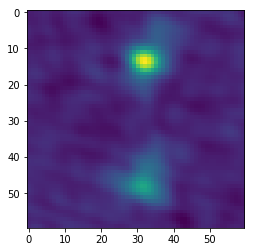

In [9]:
test_coord = SC('04 54 25.411 -29 32 46.58', unit='hourangle,deg')
plt.imshow(make_cutout(test_coord, find_closest_image(test_coord), radius=30))

Let's get lots of cutouts. Take RGZ, then find out everything below +30. Find their paths.

In [10]:
rgz = pandas.read_csv('/home/alger/myrtle1/first-xid/static_rgz_flat_2016-08-02_full_FINAL.csv')

/home/alger/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
in_racs = rgz['radio.dec'] < 30

In [12]:
rgz_paths = collections.defaultdict(list)
rgz_coords = []
rgz_names = []
for i, row in tqdm(rgz[in_racs].iterrows(), total=sum(in_racs)):
    coord = SC(ra=row['radio.ra'], dec=row['radio.dec'], unit='deg')
    path = find_closest_image(coord)
    rgz_paths[path].append(row['rgz_name'])
    rgz_names.append(row['rgz_name'])
    rgz_coords.append(coord)

Let's get all RGZ images.

In [15]:
all_cutouts = []
has_cutouts = []
for path in tqdm(rgz_paths):
    name_to_coord = dict(zip(rgz_names, rgz_coords))
    coords = [name_to_coord[name] for name in rgz_paths[path]]
    coords = SC(coords)
    cutouts = make_cutouts(coords, path)
    for c, name in zip(cutouts, rgz_paths[path]):
        if c.shape != (40, 40):
            continue
        if numpy.isnan(c).all():
            continue
        all_cutouts.append(c)
        has_cutouts.append(name)

KeyboardInterrupt: 

In [16]:
all_cutouts = numpy.array(all_cutouts)
assert len(all_cutouts) == len(has_cutouts)

Let's try something really basic with it. We might as well do PCA.

In [17]:
data = numpy.nan_to_num(all_cutouts.reshape(all_cutouts.shape[0], -1))
pca = sklearn.decomposition.PCA(n_components=50)
pca_proj = pca.fit_transform(data)
pca_recon = pca.inverse_transform(pca_proj)

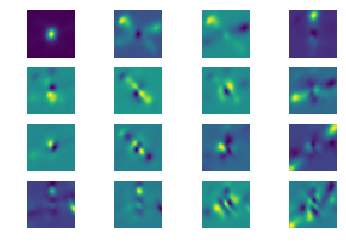

In [18]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(pca.components_[i].reshape(40, 40))
    plt.axis('off')

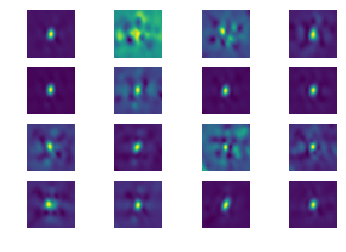

In [19]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(pca_recon[i].reshape(40, 40))
    plt.axis('off')

And since we have a PCA representation, we may as well use TSNE or UMAP.

In [48]:
rgz_indexed = rgz.set_index('rgz_name')
has_cutouts_rgz = [rgz_indexed.loc[c] for c in tqdm(has_cutouts)]
assert len(has_cutouts_rgz) == len(has_cutouts)

In [52]:
consensus = []
for r in has_cutouts_rgz:
    try:
        consensus.append(float(r['consensus.radio_level']))
    except:
        consensus.append(float(r['consensus.radio_level'].iloc[0]))

In [84]:
zs = []
for r in tqdm(has_cutouts_rgz):
    try:
        zs.append(float(r['SDSS.spec_redshift']))
    except:
        zs.append(float(r['SDSS.spec_redshift'].iloc[0]))

In [109]:
print(list(rgz.columns))

['catalog_id', 'rgz_name', 'zooniverse_id', 'overedge', 'radio.ra', 'radio.dec', 'consensus.ir_ra', 'consensus.ir_dec', 'consensus.n_total', 'consensus.n_radio', 'consensus.n_ir', 'consensus.radio_level', 'consensus.ir_level', 'radio.number_components', 'radio.number_peaks', 'radio.max_angular_extent', 'radio.total_solid_angle', 'radio.outermost_level', 'radio.max_physical_extent', 'radio.total_cross_section', 'component.peak_fluxes', 'component.peak_flux_errs', 'component.peak_ras', 'component.peak_decs', 'component.fluxes', 'component.flux_errs', 'component.angular_extents', 'component.solid_angles', 'component.physical_extents', 'component.cross_sections', 'radio.total_flux', 'radio.total_flux_err', 'radio.total_luminosity', 'radio.total_luminosity_err', 'AllWISE.designation', 'AllWISE.ra', 'AllWISE.dec', 'AllWISE.w1mpro', 'AllWISE.w1sigmpro', 'AllWISE.w1snr', 'AllWISE.w2mpro', 'AllWISE.w2sigmpro', 'AllWISE.w2snr', 'AllWISE.w3mpro', 'AllWISE.w3sigmpro', 'AllWISE.w3snr', 'AllWISE.w4m

In [134]:
ras = []
for r in tqdm(has_cutouts_rgz):
    try:
        ras.append(float(r['radio.ra']))
    except:
        ras.append(float(r['radio.ra'].iloc[0]))
        
decs = []
for r in tqdm(has_cutouts_rgz):
    try:
        decs.append(float(r['radio.dec']))
    except:
        decs.append(float(r['radio.dec'].iloc[0]))

In [143]:
# tsne = sklearn.manifold.TSNE(perplexity=50, n_iter=2000, verbose=2)
uma = umap.UMAP(n_components=4, min_dist=1e-3)

In [213]:
umap_proj = uma.fit_transform(numpy.concatenate(
    [pca_proj, numpy.array(ras)[:, None], numpy.array(decs)[:, None]], axis=1))

/home/alger/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


<IPython.core.display.Javascript object>


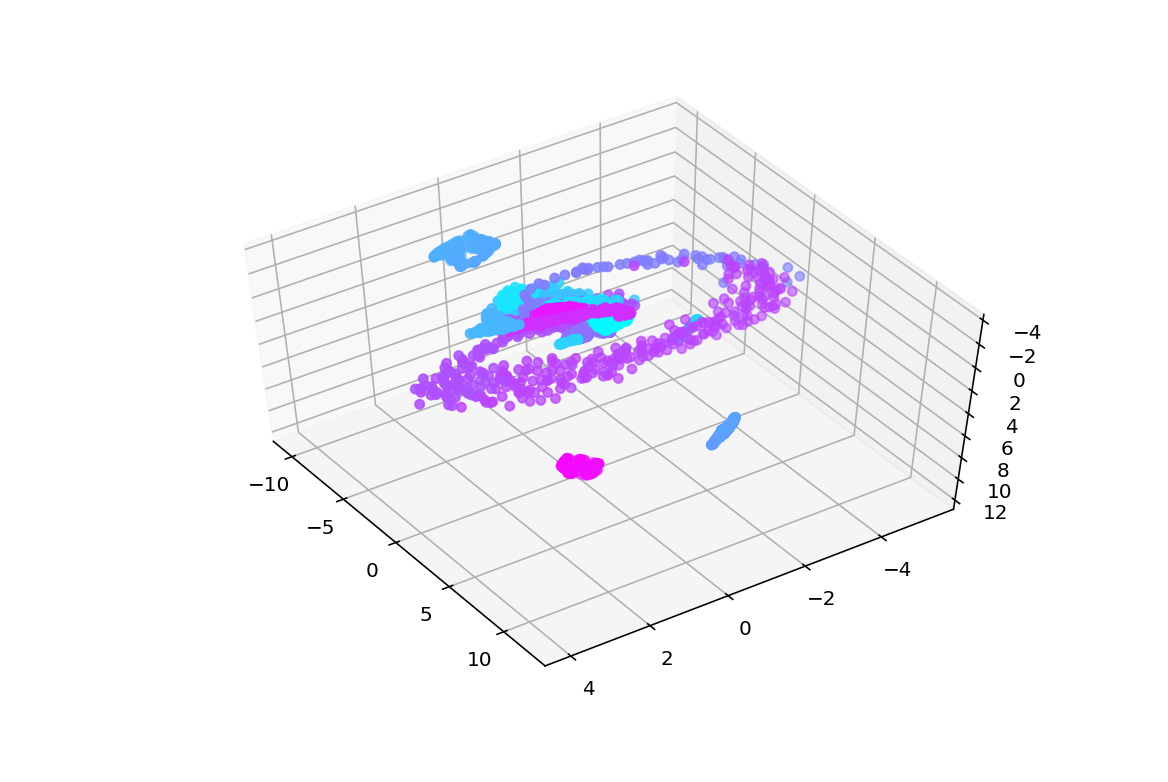

In [218]:
%matplotlib notebook
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.figure()
ax = plt.subplot(111, projection='3d')
zs = numpy.array(zs)
ax.scatter(umap_proj[:, 1], umap_proj[:, 3], umap_proj[:, 2], c=ras, cmap='cool')

In [201]:
numpy.save('/home/alger/possum/alger/rgz_racs.npy', all_cutouts)

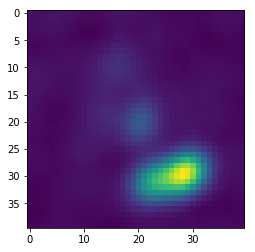

In [207]:
%matplotlib inline
plt.imshow(all_cutouts[3198])

In [208]:
dict(has_cutouts_rgz[3198])

{'catalog_id': 97014,
 'zooniverse_id': 'ARG0002cuw',
 'overedge': 0,
 'radio.ra': 157.153764634,
 'radio.dec': 20.0032806806,
 'consensus.ir_ra': -99.0,
 'consensus.ir_dec': -99.0,
 'consensus.n_total': 48,
 'consensus.n_radio': 11,
 'consensus.n_ir': 6,
 'consensus.radio_level': 0.22916666666700003,
 'consensus.ir_level': 0.545454545455,
 'radio.number_components': 1,
 'radio.number_peaks': 1,
 'radio.max_angular_extent': 18.2175873986,
 'radio.total_solid_angle': 100.203122217,
 'radio.outermost_level': 0.820992082788,
 'radio.max_physical_extent': -99.0,
 'radio.total_cross_section': -99.0,
 'component.peak_fluxes': '3.17414640449',
 'component.peak_flux_errs': '0.0232599004214',
 'component.peak_ras': '157.153937781',
 'component.peak_decs': '20.004066077',
 'component.fluxes': '5.22608793068',
 'component.flux_errs': '0.169334631081',
 'component.angular_extents': '18.2175873986',
 'component.solid_angles': '100.203122217',
 'component.physical_extents': '-99',
 'component.cross_